# Gradient Boosting for Regression

Gradient boosting is one of the most powerful and widely-used machine learning algorithms in practice. It's an ensemble method that builds a strong predictive model by combining many weak learners (typically shallow decision trees) in a sequential, additive manner. Unlike Random Forests which build trees independently, gradient boosting builds trees one at a time, where each new tree tries to correct the mistakes made by the previous ensemble.

## What is Gradient Boosting?

At its core, gradient boosting is a **functional gradient descent** algorithm that minimizes a loss function by iteratively adding weak learners. The key insight is that we can view the prediction function itself as a parameter to optimize, and we update it by moving in the direction that reduces the loss most rapidly.

The "gradient" in gradient boosting refers to the gradient of the loss function with respect to the current predictions. Each new weak learner is trained to approximate the negative gradient (the direction of steepest descent), effectively pushing the model toward better predictions.

## Why Gradient Boosting?

✅ **Key Advantages:**

1. **State-of-the-art performance**: Often achieves the best results on structured/tabular data
2. **Flexible loss functions**: Can optimize any differentiable loss function
3. **Handles mixed feature types**: Works well with numerical and categorical features
4. **Feature interactions**: Automatically captures complex interactions between features
5. **Robustness**: Less sensitive to outliers than many other algorithms (especially with robust loss functions)
6. **Feature importance**: Provides natural feature importance scores

⚠️ **Considerations:**

- Can overfit if not properly regularized (need to tune hyperparameters carefully)
- Sensitive to noisy data and outliers (with squared error loss)
- Sequential nature makes it harder to parallelize than Random Forests
- Requires careful tuning of learning rate and number of iterations



## Setup

We'll use standard Python libraries for data manipulation and visualization. The imports below provide all the tools we need to implement gradient boosting from scratch and visualize its behavior.


In [1]:

# Standard imports for data manipulation and visualization
%matplotlib inline
from __future__ import annotations

from dataclasses import dataclass
from typing import List, Tuple, Dict
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure seaborn for consistent aesthetics across all plots
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})



## Toy Dataset (5 Samples)

To build intuition for how gradient boosting works, we'll use a simple toy dataset with just 5 samples and a single feature. This small dataset allows us to:

- **Inspect every iteration** in detail
- **Visualize the entire learning process** clearly
- **Understand the mechanics** before scaling to larger problems

The targets increase roughly linearly with slight curvature, providing a simple but non-trivial regression problem.

### Loss Function: Mean Squared Error (MSE)

For regression, we'll minimize the mean squared error. For a single prediction, the loss is:

$$
L(y, F(x)) = \frac{1}{2} (y - F(x))^2
$$

Where:
- $y$ is the true target value
- $F(x)$ is the model's prediction at point $x$
- The factor of $\frac{1}{2}$ simplifies the derivative

The total loss over all samples is:

$$
\mathcal{L} = \sum_{i=1}^{n} L(y_i, F(x_i)) = \frac{1}{2} \sum_{i=1}^{n} (y_i - F(x_i))^2
$$

Our goal is to find the function $F(x)$ that minimizes this total loss.


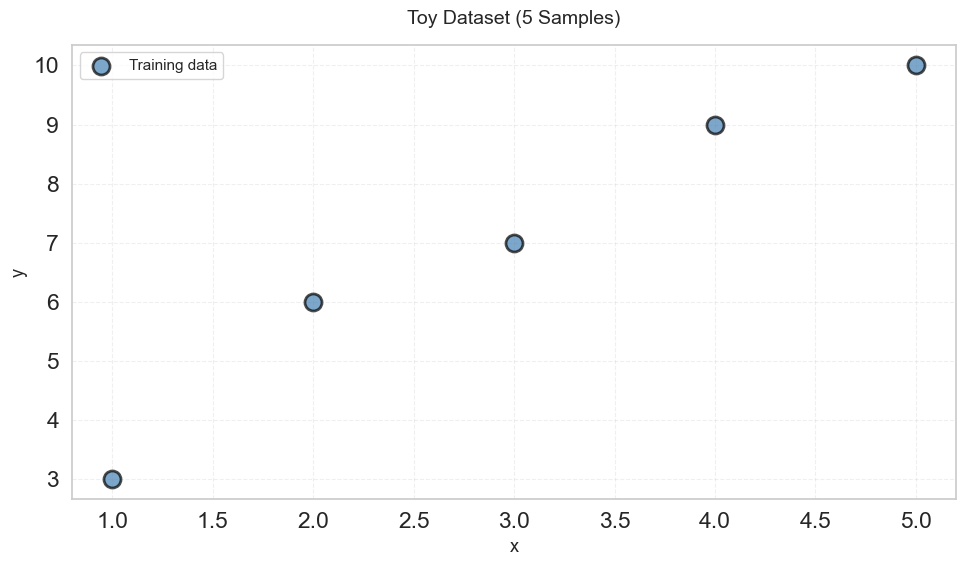

In [2]:

# Create a simple 5-sample toy dataset for demonstrating gradient boosting
# Feature X: equally spaced values from 1 to 5
X = np.array([1., 2., 3., 4., 5.], dtype=float)

# Target y: roughly linear with slight curvature
y = np.array([3., 6., 7., 9., 10.], dtype=float)

# Visualize the toy dataset
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=150, alpha=0.7, color="steelblue", edgecolors="black", linewidth=2, label="Training data", zorder=5)
plt.xlabel("x", fontsize=13)
plt.ylabel("y", fontsize=13)
plt.title("Toy Dataset (5 Samples)", fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()



## Gradient Boosting for Regression: Mathematical Foundation

Gradient boosting builds a strong predictive model by sequentially adding weak learners in an additive fashion. Let's break down the mathematics step by step.

### The Additive Model

At iteration $m$, our model is:

$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$

Where:
- $F_m(x)$ is the current ensemble prediction
- $F_{m-1}(x)$ is the previous ensemble prediction
- $h_m(x)$ is the new weak learner (decision stump) we're adding
- $\nu \in (0,1]$ is the **learning rate** (also called shrinkage), which controls how much each tree contributes

**Why use a learning rate?** A smaller learning rate makes learning more gradual, which often leads to better generalization. Think of it as taking smaller, more careful steps down the loss surface.

### Initialization: The Constant Model

Before adding any trees, we need a starting point. For MSE loss, the optimal constant prediction is simply the mean of the target values:

$$
F_0(x) = \arg\min_c \sum_i \frac{1}{2}(y_i - c)^2 = \bar{y}
$$

This makes intuitive sense: if we can only make one prediction for all data points, the mean minimizes the squared error.

### The Boosting Algorithm: Iteration Steps

At each iteration $m = 1, 2, 3, \ldots, M$:

**Step 1: Compute Pseudo-Residuals (Negative Gradient)**

The pseudo-residuals are the negative gradient of the loss function with respect to the current predictions:

$$
r_{im} = -\left.\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right\rvert_{F=F_{m-1}}
$$

For MSE loss, this simplifies beautifully to:

$$
r_{im} = y_i - F_{m-1}(x_i)
$$

These are just the **prediction errors** from the current model! This is why gradient boosting with MSE is intuitive: each new tree tries to predict what the previous ensemble got wrong.

**Step 2: Fit a Weak Learner to the Residuals**

Train a new decision tree $h_m(x)$ to predict the residuals $r_{im}$. The tree learns to approximate the negative gradient, pushing the ensemble toward lower loss.

**Step 3: Find Optimal Step Size (Optional)**

For MSE loss with trees that predict region-wise means, the optimal step size $\gamma_m = 1$. In practice, we often use a fixed learning rate $\nu < 1$ for regularization.

**Step 4: Update the Ensemble**

$$
F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)
$$

We add the new tree's predictions (scaled by the learning rate) to the ensemble.

### Key Insight: Functional Gradient Descent

This process is **gradient descent in function space**:
- In standard gradient descent, we update parameters: $\theta \leftarrow \theta - \alpha \nabla_\theta L$
- In gradient boosting, we update the function: $F \leftarrow F - \nu \cdot (\text{approx. gradient})$

The weak learner $h_m$ approximates the negative gradient, steering the ensemble toward lower loss.



## Implementing a Decision Stump (One Split, Two Leaves)

A **decision stump** is the simplest possible decision tree: it makes a single split, dividing the data into two regions (left and right), each with a constant prediction. Despite their simplicity, stumps are powerful weak learners when combined through boosting.

### What is a Decision Stump?

A stump is defined by:
1. **A threshold value** $t$: the split point
2. **Left prediction** $v_L$: constant value for $x \leq t$
3. **Right prediction** $v_R$: constant value for $x > t$

The stump's prediction function is:

$$
h(x) = \begin{cases}
v_L & \text{if } x \leq t \\
v_R & \text{if } x > t
\end{cases}
$$

### How to Fit a Stump

To fit a stump to target values (which will be residuals in our gradient boosting algorithm), we:

1. **Try all possible thresholds**: For 1D data, we consider thresholds between consecutive sorted $x$ values
2. **For each threshold**: Compute the left and right leaf predictions as the **mean** of the targets in each region
3. **Select the best**: Choose the threshold that minimizes the **sum of squared errors (SSE)**:

$$
\text{SSE} = \sum_{i: x_i \leq t} (r_i - v_L)^2 + \sum_{i: x_i > t} (r_i - v_R)^2
$$

Where $r_i$ are the target values (residuals) we're fitting to.

### Why Use Stumps?

- **Weak learners**: Stumps are intentionally simple, preventing overfitting on individual trees
- **Fast to fit**: Only $O(n \log n)$ complexity (dominated by sorting)
- **Ensemble strength**: When combined through boosting, many stumps create a powerful, piecewise-constant approximation
- **Interpretable**: Each stump represents a simple decision rule


In [3]:

@dataclass
class Stump:
    """Represents a decision stump (single-split decision tree).

    A decision stump divides the input space into two regions based on a threshold,
    and assigns a constant prediction value to each region.

    Attributes:
        threshold: The split point that divides left and right regions.
        left_value: Prediction for samples where x <= threshold.
        right_value: Prediction for samples where x > threshold.
    """
    threshold: float
    left_value: float
    right_value: float

    def predict_one(self, x: float) -> float:
        """Predicts the target for a single input value.

        Args:
            x: Input feature value.

        Returns:
            Predicted target value (left_value or right_value).
        """
        return self.left_value if x <= self.threshold else self.right_value

    def predict(self, xs: np.ndarray) -> np.ndarray:
        """Predicts targets for an array of input values.

        Uses vectorized numpy operations for efficiency.

        Args:
            xs: Array of input feature values.

        Returns:
            Array of predicted target values.
        """
        return np.where(xs <= self.threshold, self.left_value, self.right_value)


def fit_best_stump(xs: np.ndarray, targets: np.ndarray) -> Stump:
    """Fits a decision stump to minimize sum of squared errors.

    Tries all possible split points and selects the one that minimizes SSE.
    For each split, left and right predictions are the mean of their respective targets.

    Args:
        xs: Feature values (1D array).
        targets: Target values to fit (typically residuals in gradient boosting).

    Returns:
        The best Stump object with optimal threshold and predictions.
    """
    # Sort data by feature values for efficient threshold searching
    order = np.argsort(xs)
    xs_sorted = xs[order]
    ys_sorted = targets[order]

    # Generate candidate thresholds: midpoints between consecutive x values
    # Also include extreme thresholds to allow all-left or all-right splits
    thresholds = [xs_sorted[0] - 1e-9]  # Before the first point
    for i in range(len(xs_sorted) - 1):
        if xs_sorted[i] != xs_sorted[i+1]:  # Only split between distinct values
            thresholds.append(0.5 * (xs_sorted[i] + xs_sorted[i+1]))
    thresholds.append(xs_sorted[-1] + 1e-9)  # After the last point

    # Search for the threshold that minimizes SSE
    best_sse = np.inf
    best = None

    for thr in thresholds:
        # Create masks for left (<=) and right (>) regions
        left_mask = xs_sorted <= thr
        right_mask = ~left_mask

        # Get targets in each region
        left = ys_sorted[left_mask]
        right = ys_sorted[right_mask]

        # Compute region predictions as means (optimal for squared error)
        left_val = left.mean() if left.size > 0 else 0.0
        right_val = right.mean() if right.size > 0 else 0.0

        # Calculate sum of squared errors for this split
        sse = ((left - left_val)**2).sum() + ((right - right_val)**2).sum()

        # Update best if this split is better
        if sse < best_sse:
            best_sse = sse
            best = Stump(threshold=float(thr), left_value=float(left_val), right_value=float(right_val))

    assert best is not None, "Failed to find a valid stump (should never happen)"
    return best



## Training Loop: The Gradient Boosting Algorithm

Now we'll implement the complete gradient boosting algorithm. The training process iterates for $M$ rounds, where in each round we:

1. **Calculate residuals** (what the current model gets wrong)
2. **Fit a stump** to those residuals
3. **Update predictions** by adding the stump's output (scaled by learning rate)
4. **Record progress** for detailed inspection

### Logging for Transparency

To understand exactly how gradient boosting works, we'll log detailed information at each iteration:

- **Per-sample metrics**: Current prediction, residual, stump prediction, updated prediction
- **Model details**: Stump threshold and leaf values
- **Loss**: MSE after each update

This comprehensive logging allows us to:
- Verify the algorithm is working correctly
- Understand how predictions evolve iteration by iteration
- Debug if something goes wrong
- Visualize the learning dynamics

The logged data will be stored in a Pandas DataFrame for easy analysis and visualization.


In [4]:

def mse(residuals: np.ndarray) -> float:
    """Calculates the mean squared error from residuals.

    Args:
        residuals: Array of residuals (y_true - y_pred).

    Returns:
        Mean squared error as a scalar.
    """
    return float(np.mean(residuals**2))


def run_gb_mse(
    xs: np.ndarray,
    ys: np.ndarray,
    learning_rate: float = 0.1,
    n_iters: int = 5
) -> Tuple[np.ndarray, pd.DataFrame]:
    """Runs gradient boosting for regression with MSE loss.

    Implements the complete gradient boosting algorithm:
    1. Initialize with constant model (mean of y)
    2. For each iteration:
       - Compute residuals (negative gradient of MSE)
       - Fit a stump to the residuals
       - Update ensemble predictions
       - Log detailed metrics

    Args:
        xs: Feature values (1D array).
        ys: Target values (1D array).
        learning_rate: Shrinkage parameter, controls the contribution of each stump.
            Smaller values require more iterations but can improve generalization.
        n_iters: Number of boosting rounds (number of stumps to fit).

    Returns:
        Tuple of (final_predictions, log_dataframe) where:
        - final_predictions: Final ensemble predictions for all samples
        - log_dataframe: DataFrame with detailed per-iteration, per-sample logs
    """
    # Step 1: Initialize F0 as the mean of y (optimal constant for MSE)
    F = np.full_like(ys, ys.mean())
    logs = []  # Store detailed logs for each iteration and sample

    # Step 2: Boosting rounds
    for m in range(1, n_iters + 1):
        # Compute pseudo-residuals (negative gradient of MSE loss)
        # For MSE: -∂L/∂F = y - F, which are simply the prediction errors
        residuals = ys - F

        # Fit a decision stump to approximate the residuals (negative gradient)
        stump = fit_best_stump(xs, residuals)

        # Get stump predictions for all samples
        h = stump.predict(xs)

        # Update the ensemble: F_m = F_{m-1} + nu * h_m
        F_new = F + learning_rate * h

        # Calculate MSE with the updated predictions
        mse_after = mse(ys - F_new)

        # Log detailed information for each sample at this iteration
        for i in range(xs.size):
            logs.append({
                "iter": m,                     # Iteration number
                "i": i,                        # Sample index
                "x": xs[i],                    # Feature value
                "y": ys[i],                    # True target
                "F_before": F[i],              # Prediction before this update
                "residual": residuals[i],      # Residual (what we need to correct)
                "stump_pred": h[i],            # Stump's prediction (correction)
                "F_after": F_new[i],           # Prediction after update
                "mse_after": mse_after,        # MSE after update
                "threshold": stump.threshold,  # Stump split point
                "left_value": stump.left_value,   # Stump left leaf value
                "right_value": stump.right_value, # Stump right leaf value
            })

        # Update current predictions for next iteration
        F = F_new

    # Convert logs to DataFrame for easy analysis
    log_df = pd.DataFrame(logs)
    return F, log_df


# Run gradient boosting on our toy dataset
# Parameters: learning_rate=0.1 (conservative), n_iters=8 (enough to see convergence)
F_final, log_df = run_gb_mse(X, y, learning_rate=0.1, n_iters=8)

# Display first few rows to see the structure
print("Sample of detailed iteration logs:")
log_df.head()


Sample of detailed iteration logs:


,iter,i,x,y,F_before,residual,stump_pred,F_after,mse_after,threshold,left_value,right_value
0,1,0,1.0,3.0,7.0,-4.0,-1.666667,6.833333,5.208333,3.5,-1.666667,2.5
1,1,1,2.0,6.0,7.0,-1.0,-1.666667,6.833333,5.208333,3.5,-1.666667,2.5
2,1,2,3.0,7.0,7.0,0.0,-1.666667,6.833333,5.208333,3.5,-1.666667,2.5
3,1,3,4.0,9.0,7.0,2.0,2.500000,7.250000,5.208333,3.5,-1.666667,2.5
4,1,4,5.0,10.0,7.0,3.0,2.500000,7.250000,5.208333,3.5,-1.666667,2.5



### Inspect the Per-Iteration Log

The logged DataFrame provides a complete record of the gradient boosting process. Let's understand what each column represents:

**Iteration and Sample Info:**
- `iter`: Which boosting round (1, 2, 3, ...)
- `i`: Sample index (0-4 for our 5 samples)
- `x`: Feature value
- `y`: True target value

**Prediction Evolution:**
- `F_before`: Ensemble prediction before adding the current stump
- `residual`: Error that needs to be corrected (y - F_before)
- `stump_pred`: What the new stump predicts (correction to add)
- `F_after`: Updated ensemble prediction (F_before + learning_rate * stump_pred)

**Stump Details:**
- `threshold`: Where the stump splits the data
- `left_value` and `right_value`: Constant predictions in each region

**Loss Metric:**
- `mse_after`: Mean squared error across all samples after this iteration

This granular logging is invaluable for:
- **Debugging**: Verify each step follows the algorithm correctly
- **Learning**: See exactly how residuals shrink over iterations


In [5]:

# Display the complete log DataFrame
# Since there are many rows (5 samples × 8 iterations = 40 rows), we'll show:
# 1. First 10 rows to see the structure
# 2. Summary statistics
print("First 10 rows of the detailed iteration log:")
print("=" * 100)
display(log_df.head(10))

print("\n\nLast 10 rows (final iterations):")
print("=" * 100)
display(log_df.tail(10))

First 10 rows of the detailed iteration log:


,iter,i,x,y,F_before,residual,stump_pred,F_after,mse_after,threshold,left_value,right_value
0,1,0,1.0,3.0,7.000000,-4.000000,-1.666667,6.833333,5.208333,3.5,-1.666667,2.500000
1,1,1,2.0,6.0,7.000000,-1.000000,-1.666667,6.833333,5.208333,3.5,-1.666667,2.500000
2,1,2,3.0,7.0,7.000000,0.000000,-1.666667,6.833333,5.208333,3.5,-1.666667,2.500000
3,1,3,4.0,9.0,7.000000,2.000000,2.500000,7.250000,5.208333,3.5,-1.666667,2.500000
4,1,4,5.0,10.0,7.000000,3.000000,2.500000,7.250000,5.208333,3.5,-1.666667,2.500000
5,2,0,1.0,3.0,6.833333,-3.833333,-3.833333,6.450000,4.510347,1.5,-3.833333,0.958333
6,2,1,2.0,6.0,6.833333,-0.833333,0.958333,6.929167,4.510347,1.5,-3.833333,0.958333
7,2,2,3.0,7.0,6.833333,0.166667,0.958333,6.929167,4.510347,1.5,-3.833333,0.958333
8,2,3,4.0,9.0,7.250000,1.750000,0.958333,7.345833,4.510347,1.5,-3.833333,0.958333
9,2,4,5.0,10.0,7.250000,2.750000,0.958333,7.345833,4.510347,1.5,-3.833333,0.958333




Last 10 rows (final iterations):


,iter,i,x,y,F_before,residual,stump_pred,F_after,mse_after,threshold,left_value,right_value
30,7,0,1.0,3.0,5.672116,-2.672116,-2.672116,5.404904,2.218369,1.5,-2.672116,0.668029
31,7,1,2.0,6.0,6.538428,-0.538428,0.668029,6.605231,2.218369,1.5,-2.672116,0.668029
32,7,2,3.0,7.0,6.903359,0.096641,0.668029,6.970161,2.218369,1.5,-2.672116,0.668029
33,7,3,4.0,9.0,7.943049,1.056951,0.668029,8.009852,2.218369,1.5,-2.672116,0.668029
34,7,4,5.0,10.0,7.943049,2.056951,0.668029,8.009852,2.218369,1.5,-2.672116,0.668029
35,8,0,1.0,3.0,5.404904,-2.404904,-1.505068,5.254398,1.931440,2.5,-1.505068,1.003378
36,8,1,2.0,6.0,6.605231,-0.605231,-1.505068,6.454724,1.931440,2.5,-1.505068,1.003378
37,8,2,3.0,7.0,6.970161,0.029839,1.003378,7.070499,1.931440,2.5,-1.505068,1.003378
38,8,3,4.0,9.0,8.009852,0.990148,1.003378,8.110189,1.931440,2.5,-1.505068,1.003378
39,8,4,5.0,10.0,8.009852,1.990148,1.003378,8.110189,1.931440,2.5,-1.505068,1.003378



## Training Curve: MSE vs. Iterations

One of the most important diagnostics for gradient boosting is the **training curve**: how the loss (MSE in our case) decreases as we add more stumps to the ensemble.

### What to Look For

A good training curve should:
- **Decrease monotonically**: Each iteration should reduce (or at least not increase) the training loss
- **Show diminishing returns**: Early iterations make large improvements, later ones make smaller refinements
- **Eventually plateau**: The curve flattens as we approach the optimal solution

If the MSE increases or oscillates wildly, it may indicate:
- Learning rate is too high (taking too-large steps)
- Numerical instability
- Implementation bug

Let's aggregate the logged data by iteration and visualize the MSE progression.


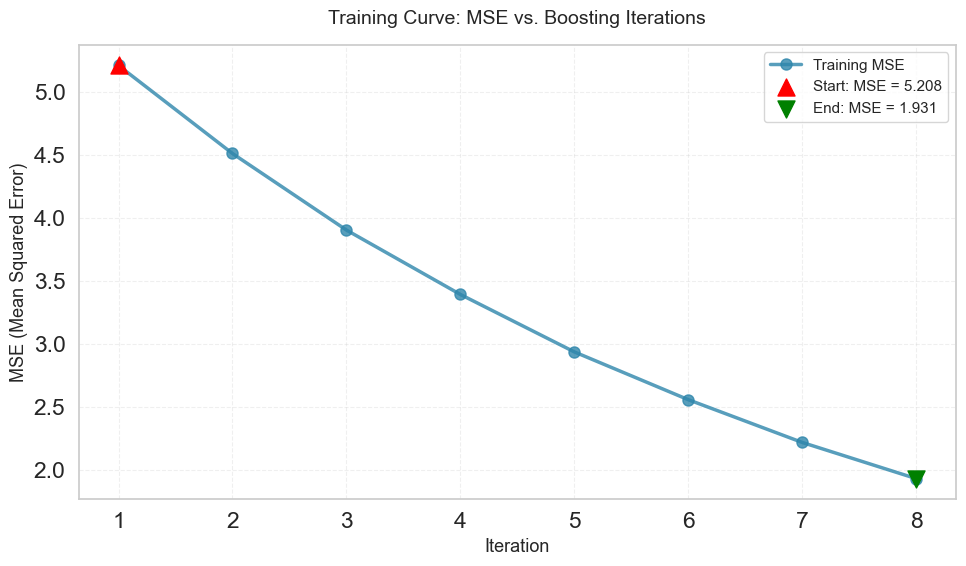


Numerical MSE progression:
 iter  mse_after
    1   5.208333
    2   4.510347
    3   3.903072
    4   3.392245
    5   2.936606
    6   2.557529
    7   2.218369
    8   1.931440

📊 Summary:
  Initial MSE: 5.2083
  Final MSE: 1.9314
  Reduction: 3.2769 (62.9%)
  Iterations: 8


In [6]:

# Aggregate MSE by iteration (one value per iteration)
# Since mse_after is the same for all samples in an iteration, we can use mean or first
mse_by_iter = log_df.groupby("iter", as_index=False)["mse_after"].mean()

# Create an improved training curve plot
plt.figure(figsize=(10, 6))
plt.plot(
    mse_by_iter["iter"],
    mse_by_iter["mse_after"],
    marker="o",
    linewidth=2.5,
    markersize=8,
    color="#2E86AB",
    alpha=0.8,
    label="Training MSE"
)

# Mark the starting and ending points for emphasis
plt.scatter(
    mse_by_iter["iter"].iloc[0],
    mse_by_iter["mse_after"].iloc[0],
    s=150,
    color="red",
    marker="^",
    zorder=5,
    label=f"Start: MSE = {mse_by_iter['mse_after'].iloc[0]:.3f}"
)
plt.scatter(
    mse_by_iter["iter"].iloc[-1],
    mse_by_iter["mse_after"].iloc[-1],
    s=150,
    color="green",
    marker="v",
    zorder=5,
    label=f"End: MSE = {mse_by_iter['mse_after'].iloc[-1]:.3f}"
)

plt.xlabel("Iteration", fontsize=13)
plt.ylabel("MSE (Mean Squared Error)", fontsize=13)
plt.title("Training Curve: MSE vs. Boosting Iterations", fontsize=14, pad=15)
plt.legend(fontsize=11, loc="upper right")
plt.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()

# Display the numerical values
print("\nNumerical MSE progression:")
print(mse_by_iter.to_string(index=False))

# Calculate and display the improvement
initial_mse = mse_by_iter["mse_after"].iloc[0]
final_mse = mse_by_iter["mse_after"].iloc[-1]
reduction = initial_mse - final_mse
reduction_pct = (reduction / initial_mse) * 100

print(f"\n📊 Summary:")
print(f"  Initial MSE: {initial_mse:.4f}")
print(f"  Final MSE: {final_mse:.4f}")
print(f"  Reduction: {reduction:.4f} ({reduction_pct:.1f}%)")
print(f"  Iterations: {len(mse_by_iter)}")



## Visualizing Prediction Evolution

One of the most insightful ways to understand gradient boosting is to watch how the ensemble predictions evolve iteration by iteration. We'll reconstruct the predictions at selected iterations and visualize how the model gradually learns to fit the data.

### What We'll See

- **F₀ (Iteration 0)**: The initial constant prediction (mean of y) - a horizontal line
- **Early iterations**: Large corrections as stumps learn the major patterns
- **Middle iterations**: Refinements as stumps learn subtler patterns
- **Later iterations**: Small adjustments as the model fine-tunes its predictions

Since our weak learners are decision stumps (piecewise constant functions with one split), the ensemble prediction $F_m(x)$ is also **piecewise constant**. As we add more stumps, the prediction becomes more complex (more "steps") and better fits the data.

### Mathematical Reconstruction

To reconstruct predictions at iteration $m$, we start with $F_0 = \bar{y}$ and add the contributions of all stumps up to iteration $m$:

$$
F_m(x) = F_0 + \nu \sum_{j=1}^{m} h_j(x)
$$

Where:
- $F_0 = \bar{y}$ is the initial constant model
- $\nu$ is the learning rate (0.1 in our example)
- $h_j(x)$ is the $j$-th stump's prediction

Let's visualize this evolution at selected iterations.


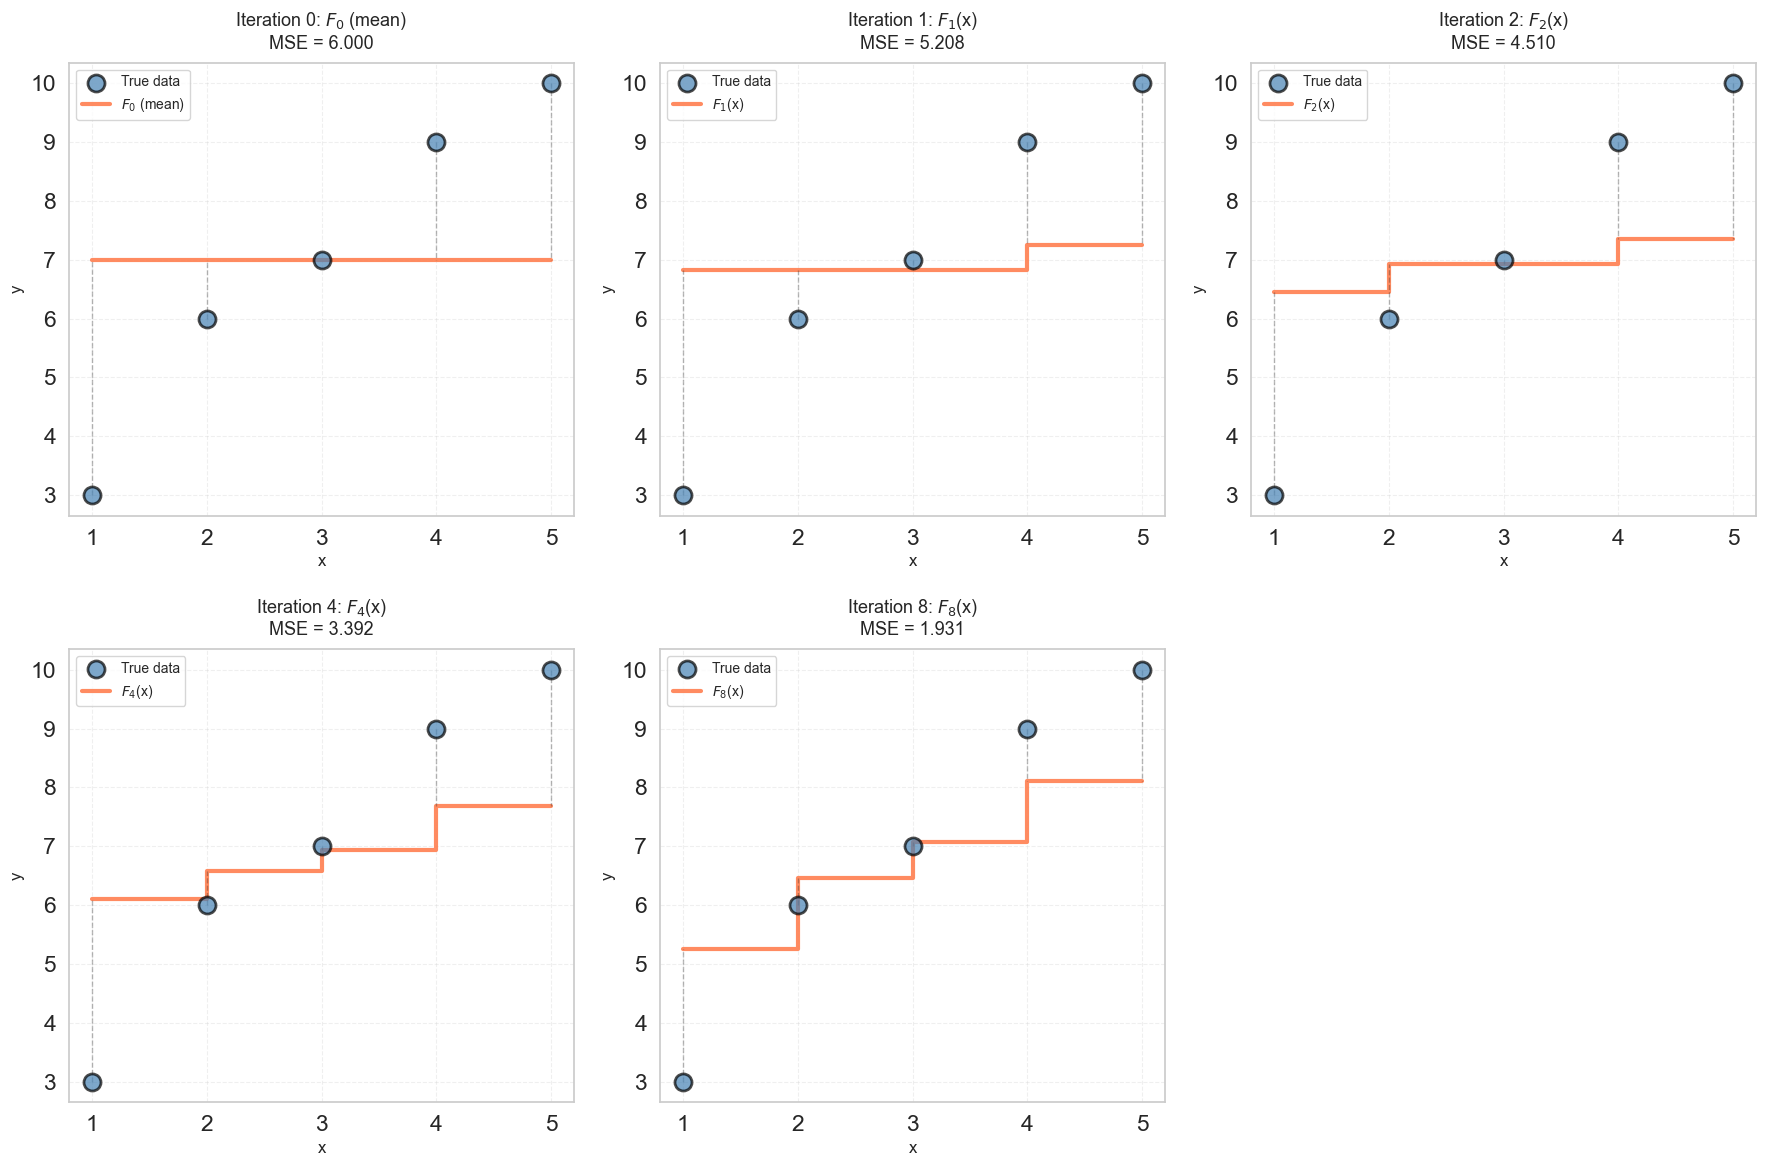


PREDICTION EVOLUTION SUMMARY
Iteration  0: MSE = 6.0000  |  Predictions: [7. 7. 7. 7. 7.]
Iteration  1: MSE = 5.2083  |  Predictions: [6.83333333 6.83333333 6.83333333 7.25       7.25      ]
Iteration  2: MSE = 4.5103  |  Predictions: [6.45       6.92916667 6.92916667 7.34583333 7.34583333]
Iteration  4: MSE = 3.3922  |  Predictions: [6.09716204 6.5763287  6.94125926 7.692625   7.692625  ]
Iteration  8: MSE = 1.9314  |  Predictions: [5.25439772 6.45472416 7.07049933 8.1101894  8.1101894 ]

💡 Observations:
   • F_0 is a constant (horizontal line) - the mean of y
   • Each iteration adds a piecewise-constant correction
   • The model gradually approaches the true data points
   • Residuals (vertical dashed lines) shrink as we add more stumps
   • The ensemble becomes more complex (more 'steps') with each iteration


In [7]:

def reconstruct_predictions(
    xs: np.ndarray,
    ys: np.ndarray,
    log_df: pd.DataFrame,
    learning_rate: float,
    upto_iter: int
) -> np.ndarray:
    """Reconstructs ensemble predictions at a specific iteration.

    Starts with F_0 (mean) and sequentially adds contributions from stumps
    up to the specified iteration.

    Args:
        xs: Feature values (1D array).
        ys: Target values (1D array) - used to calculate F_0.
        log_df: DataFrame with detailed logs from run_gb_mse.
        learning_rate: Shrinkage parameter used in training.
        upto_iter: Iteration number to reconstruct (0 = just F_0).

    Returns:
        Array of predictions F_m(x) for all samples.
    """
    # Initialize with F_0 = mean(y)
    F = np.full_like(ys, ys.mean())

    # Add contributions from each stump up to upto_iter
    for m in range(1, upto_iter + 1):
        # Extract stump predictions for this iteration, sorted by sample index
        iter_rows = log_df[log_df["iter"] == m].sort_values("i")
        h = iter_rows["stump_pred"].to_numpy()

        # Update: F_m = F_{m-1} + nu * h_m
        F = F + learning_rate * h

    return F


# Select specific iterations to visualize the evolution
selected_iters = [0, 1, 2, 4, 8]  # 0 = F_0 (initial), then progressive refinements
F0 = np.full_like(y, y.mean())  # Cache the initial prediction

# Create a subplot for each selected iteration
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten for easier indexing

for k, it in enumerate(selected_iters):
    ax = axes[k]

    # Reconstruct predictions at this iteration
    if it == 0:
        F_plot = F0
        model_name = "$F_0$ (mean)"
    else:
        F_plot = reconstruct_predictions(X, y, log_df, learning_rate=0.1, upto_iter=it)
        model_name = f"$F_{{{it}}}$(x)"

    # Calculate current MSE for this iteration
    current_mse = mse(y - F_plot)

    # Plot the data points
    ax.scatter(X, y, s=150, alpha=0.7, color="steelblue", edgecolors="black",
               linewidth=2, label="True data", zorder=5)

    # Plot the piecewise-constant ensemble prediction
    # Use steps-post to show the step function nature of the ensemble
    order = np.argsort(X)
    ax.plot(X[order], F_plot[order], drawstyle="steps-post", linewidth=3,
            color="coral", label=model_name, alpha=0.9)

    # Add vertical lines showing residuals (errors)
    for i in range(len(X)):
        ax.plot([X[i], X[i]], [y[i], F_plot[i]], 'k--', alpha=0.3, linewidth=1)

    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_title(f"Iteration {it}: {model_name}\nMSE = {current_mse:.3f}", fontsize=13, pad=10)
    ax.legend(fontsize=10, loc="upper left")
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.8)

# Hide the extra subplot (we have 5 plots but 6 subplots)
axes[5].axis("off")

plt.tight_layout()
plt.show()

# Print a summary of the evolution
print("\n" + "="*70)
print("PREDICTION EVOLUTION SUMMARY")
print("="*70)
for it in selected_iters:
    if it == 0:
        F_plot = F0
    else:
        F_plot = reconstruct_predictions(X, y, log_df, learning_rate=0.1, upto_iter=it)
    current_mse = mse(y - F_plot)
    print(f"Iteration {it:2d}: MSE = {current_mse:.4f}  |  Predictions: {F_plot}")

print("\n💡 Observations:")
print("   • F_0 is a constant (horizontal line) - the mean of y")
print("   • Each iteration adds a piecewise-constant correction")
print("   • The model gradually approaches the true data points")
print("   • Residuals (vertical dashed lines) shrink as we add more stumps")
print("   • The ensemble becomes more complex (more 'steps') with each iteration")



## Summary and Key Takeaways

### Core Concepts

1. **Gradient Boosting = Functional Gradient Descent**
   - We're not optimizing parameters, we're optimizing a function $F(x)$
   - Each new weak learner approximates the negative gradient, moving toward lower loss
   - This is analogous to gradient descent: $F \leftarrow F - \nu \cdot (\text{approx. gradient})$

2. **Pseudo-Residuals for MSE**
   - For squared error loss, the pseudo-residual (negative gradient) simplifies to: $r_i = y_i - F(x_i)$
   - These are simply the prediction errors - what the current model gets wrong
   - Each new stump tries to predict these residuals, correcting the ensemble's mistakes

3. **Additive Model Building**
   - Start with $F_0(x) = \bar{y}$ (optimal constant for MSE)
   - Sequentially add weak learners: $F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$
   - Each stump contributes a piecewise-constant correction

4. **Learning Rate (Shrinkage)**
   - $\nu \in (0, 1]$ controls how much each stump contributes
   - Smaller $\nu$ means more gradual learning, often better generalization
   - Trade-off: smaller $\nu$ requires more iterations but reduces overfitting risk

5. **Weak Learners (Decision Stumps)**
   - Simplest possible trees: one split, two constant predictions
   - Intentionally weak to prevent overfitting on individual trees
   - Strength comes from the ensemble, not individual stumps

6. **Training Dynamics**
   - Loss decreases monotonically (for convex losses like MSE)
   - Early iterations make large improvements
   - Later iterations make smaller refinements
   - Diminishing returns as the model approaches optimal solution

### When to Use Gradient Boosting

✅ **Excellent for:**
- Structured/tabular data with mixed feature types
- Problems where state-of-the-art accuracy is needed
- When you can afford iterative training (not parallelizable like Random Forests)
- Classification and regression with various loss functions
- Feature importance analysis

⚠️ **Consider alternatives for:**
- Very high-dimensional sparse data (linear models may be better)
- Real-time prediction systems (ensembles can be slow)
- When interpretability is critical (single decision tree is clearer)
- When training time is severely constrained

### Extensions and Exercises

#### 1. Experiment with Learning Rate
- Try $\nu \in \{0.01, 0.1, 0.5, 1.0\}$ with fixed iterations
- Observe the trade-off between convergence speed and potential for overshooting
- Plot MSE curves for different learning rates on the same graph

#### 2. Vary Number of Iterations
- Experiment with $M \in \{5, 10, 20, 50, 100\}$ iterations
- Watch for when additional iterations provide diminishing returns
- On a separate test set, identify when overfitting begins (if using more complex trees)

#### 3. Increase Tree Complexity
- Replace stumps with deeper trees (max depth 2-3)
- Observe faster convergence but higher risk of overfitting
- Compare train vs. test MSE to diagnose overfitting

#### 4. Try Different Loss Functions
- **Mean Absolute Error (MAE)**:
  - Derive pseudo-residuals: $r_i = \text{sign}(y_i - F(x_i))$
  - More robust to outliers than MSE
  
- **Huber Loss**:
  - Combines MSE (for small errors) and MAE (for large errors)
  - Best of both worlds: smooth and robust

#### 5. Compare with Scikit-Learn
```python
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=8, 
    learning_rate=0.1, 
    max_depth=1,  # stump
    random_state=42
)
model.fit(X.reshape(-1, 1), y)
predictions = model.predict(X.reshape(-1, 1))
```
Verify similar MSE progression and final predictions.

#### 6. Add Noise and Test Robustness
- Add Gaussian noise to targets: `y_noisy = y + np.random.normal(0, 0.5, size=y.shape)`
- Compare how MSE and MAE losses handle the noise
- Experiment with different noise levels

#### 7. Implement Early Stopping
- Split data into train/validation sets
- Stop training when validation MSE stops improving
- Prevents overfitting on more complex problems

#### 8. Feature Importance
- For multi-feature problems, track how often each feature is used for splits
- Weight by the impurity reduction achieved
- Compare feature rankings with other methods (Random Forest, permutation importance)

### Further Reading

**Foundational Papers:**
- Friedman, J. H. (2001). "Greedy Function Approximation: A Gradient Boosting Machine." *Annals of Statistics*.
- Friedman, J. H. (2002). "Stochastic Gradient Boosting." *Computational Statistics & Data Analysis*.

**Modern Implementations:**
- **XGBoost**: Extreme Gradient Boosting with regularization and engineering optimizations
- **LightGBM**: Microsoft's fast, distributed gradient boosting framework
- **CatBoost**: Yandex's gradient boosting with categorical feature handling

**Python Libraries:**
- `sklearn.ensemble.GradientBoostingRegressor` / `GradientBoostingClassifier`
- `xgboost.XGBRegressor` / `XGBClassifier`
- `lightgbm.LGBMRegressor` / `LGBMClassifier`
- `catboost.CatBoostRegressor` / `CatBoostClassifier`

### Relationship to Other Methods

- **vs. Random Forests**: GBM is sequential (stumps correct errors), RF is parallel (trees vote)
- **vs. AdaBoost**: AdaBoost reweights samples, GBM fits to gradients (more general framework)
- **vs. Neural Networks**: Both are universal function approximators, but GBM excels on tabular data
- **vs. Linear Models**: GBM captures non-linear patterns but requires more data and compute

---

**🎓 Congratulations!** You now understand the fundamentals of gradient boosting and can implement it from scratch. This foundation will help you effectively use modern gradient boosting libraries (XGBoost, LightGBM, CatBoost) and understand their hyperparameters.
